<a href="https://colab.research.google.com/github/gorkar/Synapse/blob/main/Market_Timing_vs_SIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyxirr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.2/516.2 kB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pyxirr
import yfinance as yf

def calculate_xirr(cash_flows, dates):
    return pyxirr.xirr(dates, cash_flows)

def calculate_investment_performance(index_code, investment_amount, start_date='2004-01-01', end_date='2023-12-31'):
    df = yf.download([index_code], period='1d', start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df.drop(['Close'], axis=1, inplace=True)
    df.rename(columns={'Date': 'date', 'High': 'high', 'Low': 'low', 'Adj Close': 'close', 'Volume': 'volume'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.drop_duplicates(subset=['date'], inplace=True)
    df.sort_values(by='date', inplace=True)
    df['year'] = df['date'].dt.year

    investment_tracker = pd.DataFrame(index=df.index)
    investment_tracker['perfect_investment'] = 0
    investment_tracker['worst_investment'] = 0
    investment_tracker['sip_investment'] = 0

    for year in df['year'].unique():
        year_data = df[df['year'] == year]

        # Perfect Investor
        perfect_date = year_data['close'].idxmin()
        investment_tracker.loc[perfect_date, 'perfect_investment'] += investment_amount

        # Worst Investor
        worst_date = year_data['close'].idxmax()
        investment_tracker.loc[worst_date, 'worst_investment'] += investment_amount

        # SIP Investor
        sip_date = year_data.index.min()
        investment_tracker.loc[sip_date, 'sip_investment'] += investment_amount

    investment_tracker['perfect_shares'] = investment_tracker['perfect_investment'] / df['close']
    investment_tracker['cumulative_shares_perfect'] = investment_tracker['perfect_shares'].cumsum()
    investment_tracker['worst_shares'] = investment_tracker['worst_investment'] / df['close']
    investment_tracker['cumulative_shares_worst'] = investment_tracker['worst_shares'].cumsum()
    investment_tracker['sip_shares'] = investment_tracker['sip_investment'] / df['close']
    investment_tracker['cumulative_shares_sip'] = investment_tracker['sip_shares'].cumsum()

    df['perfect_shares'] = investment_tracker['perfect_shares']
    df['perfect_investment'] = investment_tracker['perfect_investment']
    df['worst_shares'] = investment_tracker['worst_shares']
    df['worst_investment'] = investment_tracker['worst_investment']
    df['sip_shares'] = investment_tracker['sip_shares']
    df['sip_investment'] = investment_tracker['sip_investment']
    df['cumulative_shares_perfect'] = investment_tracker['cumulative_shares_perfect']
    df['cumulative_shares_worst'] = investment_tracker['cumulative_shares_worst']
    df['cumulative_shares_sip'] = investment_tracker['cumulative_shares_sip']
    df['cumulative_value_perfect'] = investment_tracker['cumulative_shares_perfect'] * df['close']
    df['cumulative_value_worst'] = investment_tracker['cumulative_shares_worst'] * df['close']
    df['cumulative_value_sip'] = investment_tracker['cumulative_shares_sip'] * df['close']

    # Create cash flow series and corresponding dates for each investor
    dates_perfect = df.loc[df['perfect_shares'] > 0, 'date'].tolist() + [df['date'].iloc[-1]]
    dates_worst = df.loc[df['worst_shares'] > 0, 'date'].tolist() + [df['date'].iloc[-1]]
    dates_sip = df.loc[df['sip_shares'] > 0, 'date'].tolist() + [df['date'].iloc[-1]]

    cash_flows_perfect = [-investment_amount] * len(dates_perfect[:-1]) + [df['cumulative_value_perfect'].iloc[-1]]
    cash_flows_worst = [-investment_amount] * len(dates_worst[:-1]) + [df['cumulative_value_worst'].iloc[-1]]
    cash_flows_sip = [-investment_amount] * len(dates_sip[:-1]) + [df['cumulative_value_sip'].iloc[-1]]

    # Calculate XIRR
    xirr_perfect = calculate_xirr(cash_flows_perfect, dates_perfect)
    xirr_worst = calculate_xirr(cash_flows_worst, dates_worst)
    xirr_sip = calculate_xirr(cash_flows_sip, dates_sip)

    return df, xirr_perfect, xirr_worst, xirr_sip

def get_plots(df, xirr_perfect, xirr_worst, xirr_sip, index_code):
  plt.figure(figsize=(12, 6))
  plt.plot(df['date'], df['close'], color='#133337', lw=1, label=f'{index_code} Close')
  plt.scatter(df.loc[df['perfect_shares'] > 0, 'date'], df.loc[df['perfect_shares'] > 0, 'close'], marker='^', color='g', label='Best Entry')
  plt.scatter(df.loc[df['worst_shares'] > 0, 'date'], df.loc[df['worst_shares'] > 0, 'close'], marker='v', color='r', label='Worst Entry')
  plt.scatter(df.loc[df['sip_shares'] > 0, 'date'], df.loc[df['sip_shares'] > 0, 'close'], marker='o', color='#ffa500', label='SIP Entry')
  plt.title('Entry Points of Different types of Investors')
  ax = plt.gca()
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(12, 6))
  plt.plot(df['date'], df['cumulative_value_perfect'], color='g', label=f'Best Investor (XIRR: {xirr_perfect:.2%})')
  plt.plot(df['date'], df['cumulative_value_worst'], color='r', label=f'Worst Investor (XIRR: {xirr_worst:.2%})')
  plt.plot(df['date'], df['cumulative_value_sip'], color='#ffa500', label=f'SIP Investor (XIRR: {xirr_sip:.2%})')
  plt.plot(df['date'], df['sip_investment'].cumsum(), color='#069af3', label='Cum Investments')
  plt.title('Cumulative Cumulative Investment Value for Each Investor Type')
  ax = plt.gca()
  ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
  plt.legend()
  plt.grid(True)
  plt.show()





In [ ]:
index_code = 'TITAN.NS'
investment_amount = 120000
df, xirr_perfect, xirr_worst, xirr_sip = calculate_investment_performance(index_code, investment_amount)
df.head()

[*********************100%%**********************]  1 of 1 completed


,date,Open,high,low,close,volume,year,perfect_shares,perfect_investment,worst_shares,worst_investment,sip_shares,sip_investment,cumulative_shares_perfect,cumulative_shares_worst,cumulative_shares_sip,cumulative_value_perfect,cumulative_value_worst,cumulative_value_sip
0,2004-01-01,6.3525,6.5205,6.3525,5.832673,1541540,2004,0.0,0,0.0,0,20573.757264,120000,0.0,0.0,20573.757264,0.0,0.0,120000.000000
1,2004-01-02,6.5205,6.5690,6.3870,5.793424,1706280,2004,0.0,0,0.0,0,0.000000,0,0.0,0.0,20573.757264,0.0,0.0,119192.501767
2,2004-01-05,6.5205,6.5545,6.1315,5.698686,1920180,2004,0.0,0,0.0,0,0.000000,0,0.0,0.0,20573.757264,0.0,0.0,117243.385016
3,2004-01-06,6.0825,6.4235,6.0825,5.566956,2188640,2004,0.0,0,0.0,0,0.000000,0,0.0,0.0,20573.757264,0.0,0.0,114533.202333
4,2004-01-07,6.1315,6.2775,5.8880,5.580490,2549280,2004,0.0,0,0.0,0,0.000000,0,0.0,0.0,20573.757264,0.0,0.0,114811.639174


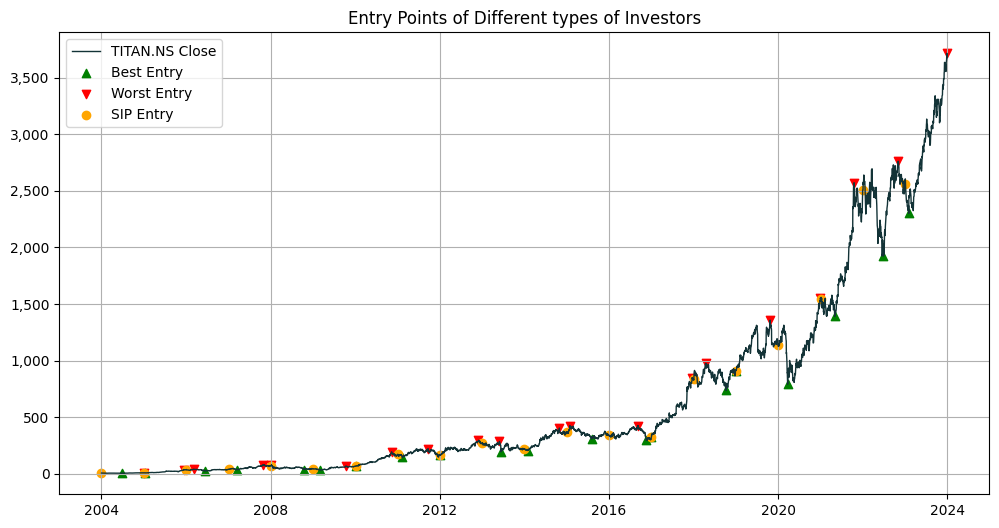

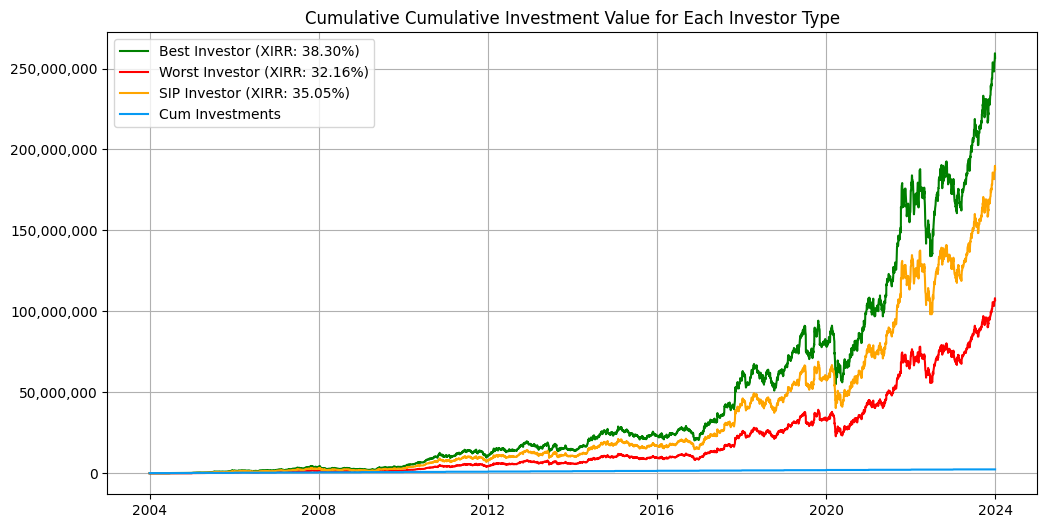

In [ ]:
get_plots(df, xirr_perfect, xirr_worst, xirr_sip, index_code)